In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import numpy as np


In [89]:
# --- 1. CONFIGURACIÓN INICIAL ---
# ==========================================================
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "models/221025MG_backbone.ssl.pth"

# Coloca la ruta a tu dataset de PRUEBA (con carpetas de clases)
PATH_DATASET = "../.medmnist/tissuemnist.npz"

# ¿Cuántas clases tiene tu dataset de PRUEBA?
NUM_CLASES =8

# Parámetros
BATCH_SIZE = 64
EPOCHS_DE_PRUEBA = 20
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


In [90]:

# --- 2. CARGAR Y CONGELAR EL BACKBONE (MODIFICADO PARA MOCO) ---
print("Cargando modelo SSL...")

# 🧠 Paso 1: Carga la arquitectura de destino (un ResNet18 estándar)
model = models.resnet18(pretrained=False) # No necesitamos pesos de ImageNet

# 🧠 Paso 2: Carga tu checkpoint de PyTorch Lightning
checkpoint = torch.load(PATH_MODELO_SSL, map_location=DEVICE)

# Los pesos reales están en la llave 'state_dict'
state_dict = checkpoint

# 🧠 Paso 3: ¡REMAPEAR LAS LLAVES!
# Tus pesos del backbone están guardados con un prefijo.
# Debemos quitar "encoder_q.0." de cada llave.
# (p.ej. "encoder_q.0.conv1.weight" -> "conv1.weight")

prefix_del_backbone = "encoder_q.0."
new_state_dict = OrderedDict() # Usamos un OrderedDict

for k, v in state_dict.items():
    if k.startswith(prefix_del_backbone):
        # Quita el prefijo
        new_key = k[len(prefix_del_backbone):]
        new_state_dict[new_key] = v

# 🧠 Paso 4: Carga el state_dict "limpio" en tu modelo ResNet18
# Usamos strict=False porque nuestro backbone SSL (encoder_q.0)
# fue creado sin la capa 'fc', así que es normal que falten
# las llaves 'fc.weight' y 'fc.bias'.
model.load_state_dict(new_state_dict, strict=False)

print("Backbone ResNet18 extraído del checkpoint de MoCo.")

# 🧊 Paso 5: ¡Congela todo el backbone!
for param in model.parameters():
    param.requires_grad = False

print("Backbone congelado.")


# --- 3. REEMPLAZAR LA CABEZA DE CLASIFICACIÓN ---

# Obtenemos el número de features que entran a la última capa
in_features = model.fc.in_features # Esto es 512 para ResNet18

# 🎯 Reemplazamos la "cabeza" (model.fc) por un clasificador lineal NUEVO
# Esta es la ÚNICA parte del modelo que se entrenará
model.fc = nn.Linear(in_features, NUM_CLASES)

# Mueve el modelo completo al dispositivo
model = model.to(DEVICE)

print(f"Cabeza de clasificación reemplazada. Salida para {NUM_CLASES} clases.")


Cargando modelo SSL...
Backbone ResNet18 extraído del checkpoint de MoCo.
Backbone congelado.
Cabeza de clasificación reemplazada. Salida para 8 clases.


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [91]:
# Cargar archivo
data = np.load(PATH_DATASET)

# Revisar las llaves disponibles
print("Llaves en el .npz:", data.keys())

# Extraer imágenes y etiquetas
x_train = data["train_images"]      # normalmente shape (N, 28, 28)
y_train = data["train_labels"].squeeze()
x_val = data["val_images"]
y_val = data["val_labels"].squeeze()

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")

Llaves en el .npz: KeysView(NpzFile '../.medmnist/tissuemnist.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...)
x_train: (165466, 28, 28), y_train: (165466,)
x_val: (23640, 28, 28), y_val: (23640,)


In [92]:
from torch.utils.data import Dataset, DataLoader

# --- 5. DEFINIR UN DATASET PERSONALIZADO PARA .NPZ ---

data_transform = transforms.Compose([
    transforms.Resize(224),               # redimensiona la imagen
    transforms.CenterCrop(224),           # recorta el centro
    transforms.ToTensor(),                # convierte a tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # normalización ImageNet
                         std=[0.229, 0.224, 0.225])
])


class BreastMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])

        # Convertir de [H, W] a [H, W, 3] (porque el modelo espera RGB)
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)

        # Convertir a PIL y aplicar transformaciones (si existen)
        from PIL import Image
        img = Image.fromarray((img * 255).astype(np.uint8))  # pasar a 0–255

        if self.transform:
            img = self.transform(img)

        return img, label


# --- 6. CREAR DATASETS Y DATALOADERS ---

train_dataset = BreastMNISTDataset(x_train, y_train, transform=data_transform)
val_dataset = BreastMNISTDataset(x_val, y_val, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Dataset cargado. Tamaño train: {len(train_dataset)}, val: {len(val_dataset)}")


Dataset cargado. Tamaño train: 165466, val: 23640


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [93]:
# --- ENTRENAR LA CABEZA LINEAL CON VALIDACIÓN ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

print("Iniciando entrenamiento de la cabeza lineal (Linear Probing)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza finalizado.")


Iniciando entrenamiento de la cabeza lineal (Linear Probing)...
Epoch 1/20 - Train Loss: 1.6444 - Val Loss: 1.5918 - Val Acc: 41.05%
Epoch 2/20 - Train Loss: 1.5662 - Val Loss: 1.5522 - Val Acc: 42.47%
Epoch 3/20 - Train Loss: 1.5398 - Val Loss: 1.5316 - Val Acc: 43.61%


KeyboardInterrupt: 

In [ ]:
# --- 6. EVALUAR EL RENDIMIENTO ---

# (Esta sección es idéntica a la anterior)
print("Evaluando en el set de validación...")

model.eval() 
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# --- RESULTADO FINAL ---
accuracy = 100 * correct / total
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"   Accuracy en el set de validación: {accuracy:.2f} %")
print("========================================================")

Evaluando en el set de validación...

🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉
   Accuracy en el set de validación: 55.26 %


Extrayendo embeddings: 100%|█████████████████████████████████████████| 370/370 [00:41<00:00,  8.96it/s]
/lustre/proyectos/p032/env/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Embeddings shape: (23640, 512)
Calculando t-SNE (puede tardar un par de minutos)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23640 samples in 0.002s...
[t-SNE] Computed neighbors for 23640 samples in 13.538s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23640
[t-SNE] Computed conditional probabilities for sample 2000 / 23640
[t-SNE] Computed conditional probabilities for sample 3000 / 23640
[t-SNE] Computed conditional probabilities for sample 4000 / 23640
[t-SNE] Computed conditional probabilities for sample 5000 / 23640
[t-SNE] Computed conditional probabilities for sample 6000 / 23640
[t-SNE] Computed conditional probabilities for sample 7000 / 23640
[t-SNE] Computed conditional probabilities for sample 8000 / 23640
[t-SNE] Computed conditional probabilities for sample 9000 / 23640
[t-SNE] Computed conditional probabilities for sample 10000 / 23640
[t-SNE] Computed conditional probabilities for sample 11000 / 23640
[t-SNE] Computed conditional prob

/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Etiquetas únicas: [0 1 2 3 4 5 6 7]


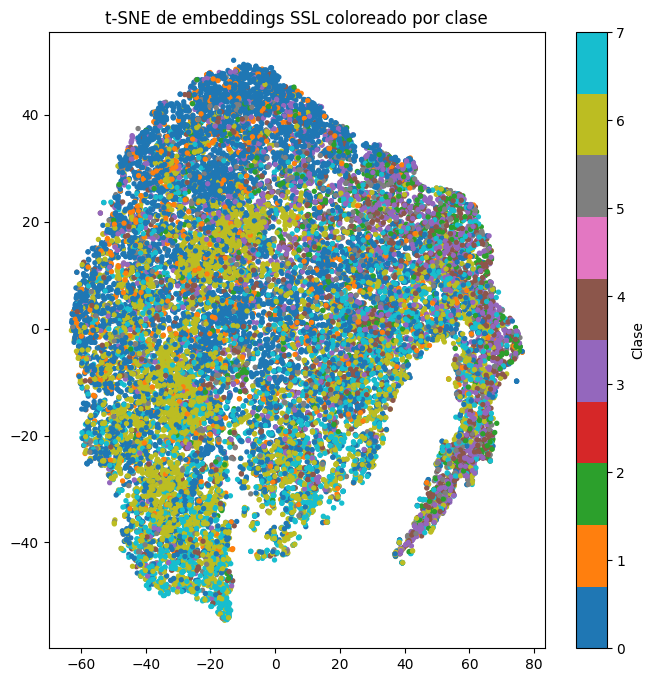

In [94]:
# --- t-SNE sobre embeddings del backbone SSL ---

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1️⃣ Preparamos solo el backbone (quitamos la cabeza fc)
backbone_ssl = nn.Sequential(*list(model.children())[:-1])  # quitar fc
backbone_ssl.eval().to(DEVICE)

# 2️⃣ Extraemos embeddings del conjunto de validación
all_embeddings = []

with torch.no_grad():
    for imgs, _ in tqdm(val_loader, desc="Extrayendo embeddings"):
        imgs = imgs.to(DEVICE)
        feats = backbone_ssl(imgs).squeeze()  # (B, 512, 1, 1) -> (B, 512)
        all_embeddings.append(feats.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)
print("Embeddings shape:", all_embeddings.shape)

# 3️⃣ Reducir dimensionalidad con t-SNE
print("Calculando t-SNE (puede tardar un par de minutos)...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, verbose=1)
emb_2d = tsne.fit_transform(all_embeddings)

# 4️⃣ Graficar

# Obtener todas las etiquetas de val_loader
all_labels = np.concatenate([y.numpy().ravel() for _, y in val_loader], axis=0)
print("Etiquetas únicas:", np.unique(all_labels))  # debería mostrar [0,1]

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab10", s=8)
plt.colorbar(label="Clase")
plt.title("t-SNE de embeddings SSL coloreado por clase")
plt.show()


Calculando UMAP (puede tardar unos segundos)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


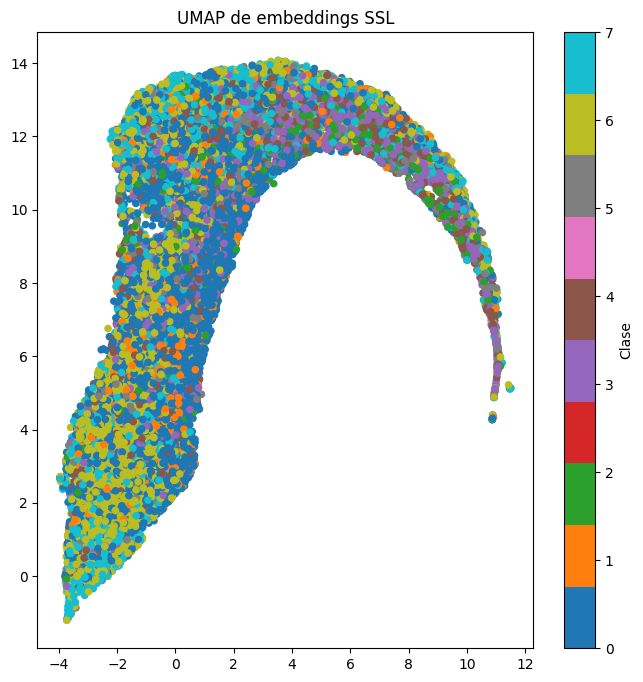

In [95]:
# --- 3. UMAP ---
import umap
print("Calculando UMAP (puede tardar unos segundos)...")
umap_2d = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
emb_2d = umap_2d.fit_transform(all_embeddings)

# --- 4. GRAFICAR ---
plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab10", s=20)
plt.colorbar(label="Clase")
plt.title("UMAP de embeddings SSL")
plt.show()